In [ ]:
import numpy as np
from scipy import linalg
import sys
sys.path.append('/Models')
from utils import find_nearest
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pickle as pkl

# --- Helper Functions ---
def load_pickle(path):
    with open(path, 'rb') as f:
        return pkl.load(f)
    
Data_path = 'ADD YOUR PATH HERE'

# Plots and analyses for the Heisenberg model

#### Initial states

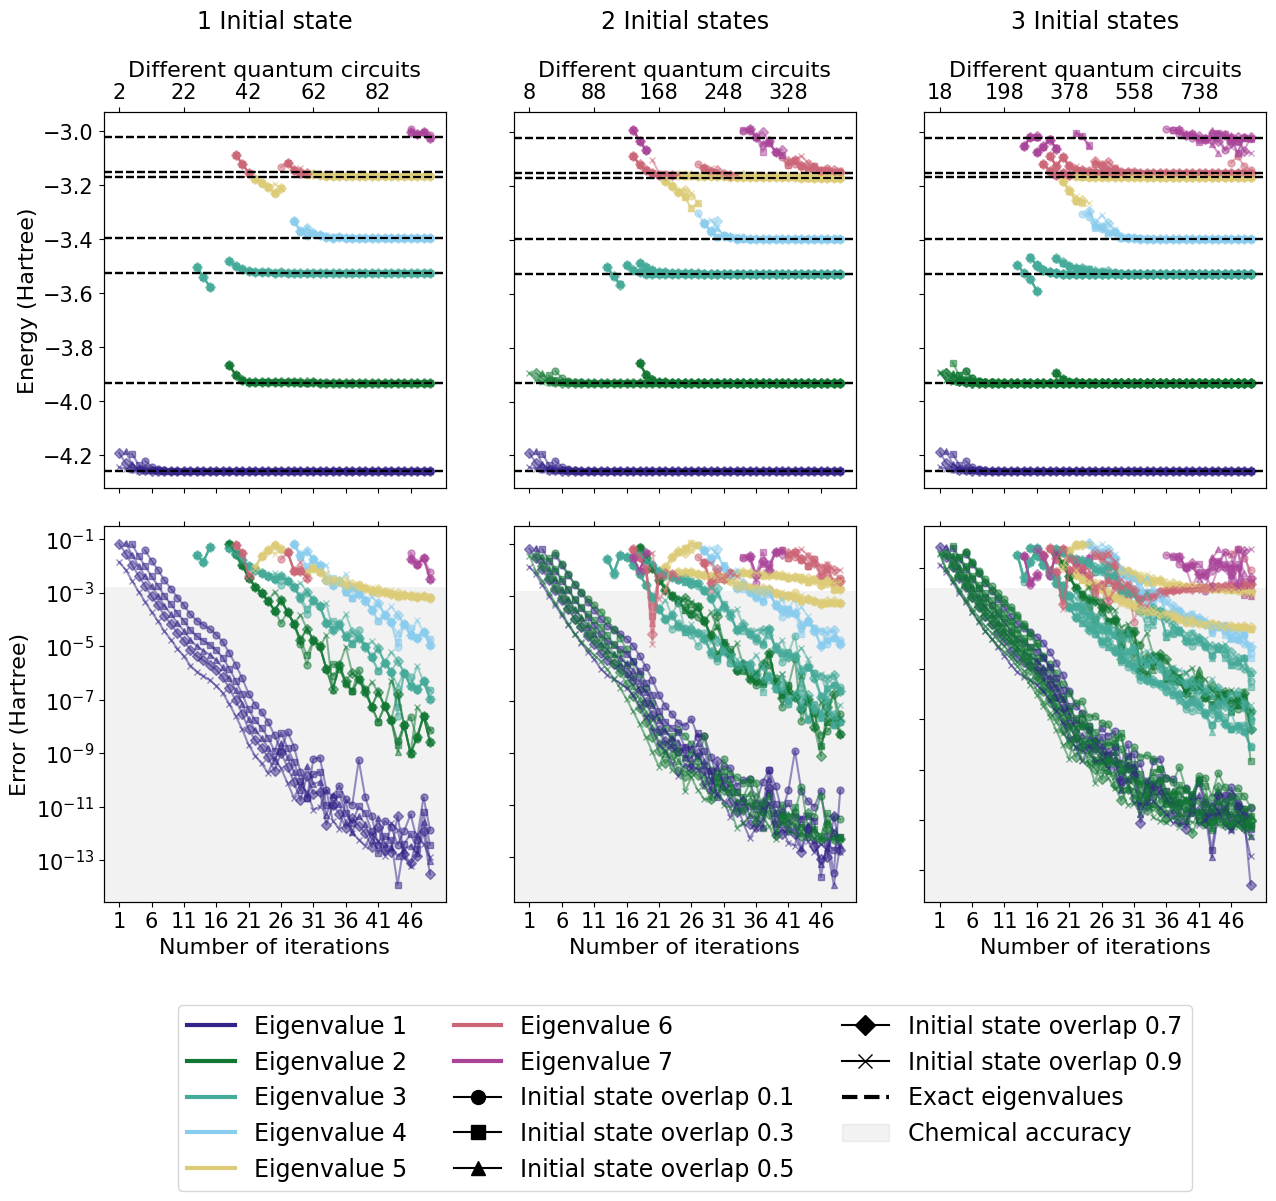

In [ ]:


# --- Configuration ---
Nstates = 7
num_tracks_per_state = 10
sites = 10
overlap_list = [0.1, 0.3, 0.5, 0.7, 0.9]

markers = ['o', 's', '^', 'D', 'x']
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499']

# Legend handles
lines = ['--']
lines_handles = [mlines.Line2D([], [], color='black', label="Exact eigenvalues", linestyle='--', linewidth=3)]
color_dic = {f'Eigenvalue {i+1}': colors[i] for i in range(Nstates)}
markers_dic = {f'Initial state overlap {val}': marker for val, marker in zip(overlap_list, markers)}
color_handles = [mlines.Line2D([], [], color=color, label=label, linewidth=3) for label, color in color_dic.items()]
overlap_handles = [mlines.Line2D([], [], color='black', label=label, marker=marker, markersize=10)
                   for label, marker in markers_dic.items()]
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
handles = color_handles + overlap_handles + lines_handles + gray_region_handle



# --- Plot Setup ---
plt.figure(figsize=(15, 10))
index_p = 1

# --- Main Loop ---
for noverlap in range(3):
    Ninitial = noverlap + 1

    for over_idx, overlap in enumerate(overlap_list):
        size = 2**sites
      

        eig_data = load_pickle(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl')
        eigvals = np.unique(np.round(np.sort(eig_data['eigvals']), 12))
        norm_val = eig_data['norm']

        # Dynamic file loading
        suffix = f"{overlap*10}"
        if noverlap == 1:
            suffix += f"_2nd{overlap*10}"
        elif noverlap == 2:
            suffix += f"_2nd{overlap*10}_3rd{overlap}"

        T = load_pickle(f'{Data_path}/T_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')
        S = load_pickle(f'{Data_path}/S_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')

        # Track eigenvalue evolution
        list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
        list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

        for i in range(1, 50):
            dim = Ninitial * i
            Ttemp = T[:dim, :dim]
            Stemp = S[:dim, :dim]

            # SVD cleanup
            U, s_vals, Vh = np.linalg.svd(Stemp)
            U, Vh = np.conj(U).T, np.conj(Vh).T
            valid = s_vals > 1e-10
            Ttemp = Vh @ Ttemp @ U
            Stemp = Vh @ Stemp @ U
            Ttemp = Ttemp[valid][:, valid]
            Stemp = Stemp[valid][:, valid]

            eigsv = linalg.eig(Ttemp, Stemp)[0]
            eigsv_angle = -np.angle(eigsv)
            eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3
            eigsv_angle = np.sort(eigsv_angle)

            assigned_sublists = [set() for _ in range(Nstates)]

            for elem in eigsv_angle:
                _, idx = find_nearest(eigvals, elem)
                if idx >= Nstates:
                    continue

                valid_idxs, diffs = [], []

                for k in range(num_tracks_per_state):
                    list_idx = num_tracks_per_state * idx + k
                    if list_idx in assigned_sublists[idx] or i in list_iter[list_idx]:
                        continue
                    if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                        continue

                    valid_idxs.append(list_idx)
                    last_val = list_eigs[list_idx][-1] if list_eigs[list_idx] else None
                    diffs.append(abs(last_val - elem) if last_val else 0.05)

                if diffs:
                    best_idx = valid_idxs[np.argmin(diffs)]
                    list_eigs[best_idx].append(elem)
                    list_iter[best_idx].append(i)
                    assigned_sublists[idx].add(best_idx)

        # --- Plot Results ---
        for p, (iters, eigvals_list) in enumerate(zip(list_iter, list_eigs)):
            if len(eigvals_list) < 3:
                continue
            state_idx = p // num_tracks_per_state
            color = colors[state_idx]
            marker = markers[over_idx]

            ax1 = plt.subplot(2, 3, index_p)
            ax1.plot(iters, eigvals_list, color=color, marker=marker, markersize=5, alpha=0.5)

            ax2 = plt.subplot(2, 3, index_p + 3)
            error = np.abs(np.array(eigvals_list) - eigvals[state_idx])
            ax2.plot(iters, error, color=color, marker=marker, markersize=5, alpha=0.5)

        ax1 = plt.subplot(2, 3, index_p)
        for val in eigvals[:Nstates]:
            ax1.axhline(y=val, color='black', linestyle='--')

    index_p += 1

# --- Axis Labeling & Styling ---
ite = np.arange(1, 50, 5)
ite2 = np.arange(1, 50, 10)

for i in range(1, 4):
    top = plt.subplot(2, 3, i)
    bottom = plt.subplot(2, 3, i + 3)

    if i == 1:
        top.set_ylabel('Energy (Hartree)', fontsize=16)
        bottom.set_ylabel('Error (Hartree)', fontsize=16)
        bottom.tick_params('y', labelsize=15)
        top.tick_params('y', labelsize=15)
    else:
        top.set_yticklabels([])
        bottom.set_yticklabels([])
        bottom.tick_params('y', labelsize=15,labelleft=False)

    top.set_xticks(ite)
    top.set_xticklabels([])
    bottom.set_xticks(ite)
    bottom.set_xticklabels(ite, size=15)
    bottom.set_xlabel('Number of iterations', fontsize=16)
    bottom.set_yscale('log')
    bottom.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)

    top.set_title(f"{i} Initial state{'s' if i > 1 else ''}", fontsize=17, pad=60)

    top_tw = top.twiny()
    top_tw.set_xlim(top.get_xlim())
    top_tw.set_xticks(ite2)
    top_tw.set_xticklabels([i*(i-1) +(x)*i*(i+1) for x in ite2], size=15)
    top_tw.set_xlabel("Different quantum circuits", fontsize=16)

    bottom_tw = bottom.twiny()
    bottom_tw.set_xlim(bottom.get_xlim())
    bottom_tw.set_xticks(ite2)
    bottom_tw.set_xticklabels([])

plt.subplots_adjust(hspace=0.1, top=0.9)
plt.legend(handles=handles, loc='lower center', fontsize=17, bbox_to_anchor=(-0.7, -0.8), ncol=3)
plt.savefig(f'{Data_path}/figure2.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
noverlap = 0
Ninitial = noverlap + 1

overlap = 0.5
sites = 10
size = 2**sites


eig_data = load_pickle(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl')
eigvals = np.sort(eig_data['eigvals'])
norm_val = eig_data['norm']

# Dynamic file loading
suffix = f"{overlap*10}"
if noverlap == 1:
    suffix += f"_2nd{overlap*10}"
elif noverlap == 2:
    suffix += f"_2nd{overlap*10}_3rd{overlap}"

T = load_pickle(f'{Data_path}/T_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')
S = load_pickle(f'{Data_path}/S_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')

i = 49
dim = Ninitial * i
Ttemp = T[:dim, :dim]
Stemp = S[:dim, :dim]

# SVD cleanup
U, s_vals, Vh = np.linalg.svd(Stemp)
U, Vh = np.conj(U).T, np.conj(Vh).T
valid = s_vals > 1e-10
Ttemp = Vh @ Ttemp @ U
Stemp = Vh @ Stemp @ U
Ttemp = Ttemp[valid][:, valid]
Stemp = Stemp[valid][:, valid]

eigsv, eigsvecs = linalg.eig(Ttemp, Stemp)
eigsv_angle = -np.angle(eigsv)
eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3


In [ ]:
eigvals[:10] # First 7 eigenvalues (including degeneracies)

array([-4.25803521, -3.93067359, -3.93067359, -3.52704357, -3.39619827,
       -3.16815083, -3.16815083, -3.15052211, -3.15052211, -3.02159446])

In [ ]:
eigsv_angle # 0 degeneracies, 5 states

array([-4.25803521, -3.93067359, -3.52704346, -3.39618736, -3.16751165,
       -3.02492111, -2.94760854, -2.76802456, -2.65438189, -2.52613283,
       -2.35095899, -2.23039197,  2.24932215,  2.18852014,  2.10777006,
        2.0167725 ,  1.85847797,  1.73693831,  1.59921575,  1.46250623,
        1.30610919,  1.16524618,  0.98031066,  0.84371656,  0.66989576,
       -2.00177139, -1.90538813, -1.77624354, -1.58295618, -1.44770919,
       -1.25859222,  0.50945785,  0.36971085,  0.19870611,  0.04541409,
       -0.09704458, -0.93479291, -0.77590474, -0.59258343, -0.27721243,
       -0.42742829, -1.11821059])

In [14]:
noverlap = 1
Ninitial = noverlap + 1

overlap = 0.5
sites = 10
size = 2**sites


eig_data = load_pickle(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl')
eigvals = np.sort(eig_data['eigvals'])
norm_val = eig_data['norm']

# Dynamic file loading
suffix = f"{overlap*10}"
if noverlap == 1:
    suffix += f"_2nd{overlap*10}"
elif noverlap == 2:
    suffix += f"_2nd{overlap*10}_3rd{overlap}"

T = load_pickle(f'{Data_path}/T_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')
S = load_pickle(f'{Data_path}/S_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')


i = 49
dim = Ninitial * i
Ttemp = T[:dim, :dim]
Stemp = S[:dim, :dim]

# SVD cleanup
U, s_vals, Vh = np.linalg.svd(Stemp)
U, Vh = np.conj(U).T, np.conj(Vh).T
valid = s_vals > 1e-10
Ttemp = Vh @ Ttemp @ U
Stemp = Vh @ Stemp @ U
Ttemp = Ttemp[valid][:, valid]
Stemp = Stemp[valid][:, valid]

eigsv, eigsvecs = linalg.eig(Ttemp, Stemp)
eigsv_angle = -np.angle(eigsv)
eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3


In [15]:
eigvals[:10] # First 7 eigenvalues (including degeneracies)

array([-4.25803521, -3.93067359, -3.93067359, -3.52704357, -3.39619827,
       -3.16815083, -3.16815083, -3.15052211, -3.15052211, -3.02159446])

In [ ]:
eigsv_angle # 1 degeneracies, 5 states

array([-4.25803521, -3.93067359, -3.93067358, -3.39618296, -3.52704335,
       -3.52704355,  2.24981483,  2.24940139,  2.19843087,  2.18639589,
        2.1119067 ,  2.10933552,  2.02513154,  2.01449159,  1.89550023,
        1.86129293,  1.79053104,  1.74078285,  1.66293013,  1.60550636,
        1.51381971,  1.46808728, -3.1676165 , -3.16626753, -3.14650204,
        1.349867  ,  1.3135944 ,  1.23594171,  1.17654372, -3.01465392,
       -2.95006186, -2.94711822, -2.88313656,  1.06172086,  0.98823454,
        0.91812509,  0.85883856, -2.74228109, -2.70402599, -2.60600245,
       -2.59643954, -2.50505349, -2.39739495, -2.33715019, -2.28969641,
       -2.21093974, -2.16799964,  0.75141574,  0.68031295,  0.5971403 ,
        0.52934611,  0.42655167,  0.38830106, -1.98840002, -1.97123186,
        0.26731264,  0.22136978,  0.1066578 ,  0.06990579, -0.03875487,
       -0.0743801 , -1.84602481, -1.79547293, -1.73569952, -1.63527918,
       -0.21628077, -0.26228216, -1.5456725 , -1.47895969, -1.43

In [69]:
noverlap = 2
Ninitial = noverlap + 1

overlap = 0.5
sites = 10
size = 2**sites


eig_data = load_pickle(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl')
eigvals = np.sort(eig_data['eigvals'])
norm_val = eig_data['norm']

# Dynamic file loading
suffix = f"{overlap*10}"
if noverlap == 1:
    suffix += f"_2nd{overlap*10}"
elif noverlap == 2:
    suffix += f"_2nd{overlap*10}_3rd{overlap}"

T = load_pickle(f'{Data_path}/T_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')
S = load_pickle(f'{Data_path}/S_{sites}_200Heisenberg_line_3evol_random_overlap{suffix}.pkl')


i = 28
dim = Ninitial * i
Ttemp = T[:dim, :dim]
Stemp = S[:dim, :dim]

# SVD cleanup
U, s_vals, Vh = np.linalg.svd(Stemp)
U, Vh = np.conj(U).T, np.conj(Vh).T
valid = s_vals > 1e-10
Ttemp = Vh @ Ttemp @ U
Stemp = Vh @ Stemp @ U
Ttemp = Ttemp[valid][:, valid]
Stemp = Stemp[valid][:, valid]

eigsv, eigsvecs = linalg.eig(Ttemp, Stemp)
eigsv_angle = -np.angle(eigsv)
eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3

In [55]:
eigvals[:10] # First 7 eigenvalues (including degeneracies)

array([-4.25803521, -3.93067359, -3.93067359, -3.52704357, -3.39619827,
       -3.16815083, -3.16815083, -3.15052211, -3.15052211, -3.02159446])

In [ ]:
eigsv_angle # 1 degeneracies, 6 states

array([-4.25803521, -3.93057331, -3.93067359, -3.93067359, -3.36959677,
       -3.52136035, -3.52703823, -3.52701999, -3.16745295, -3.1526489 ,
       -3.13662042, -2.95427182, -2.92677887, -2.91172868, -2.73588036,
       -2.70860792, -2.60630295, -2.5442929 , -2.5007668 , -2.36888635,
       -2.307466  , -2.27823156, -2.07663727, -1.97411363, -1.99925948,
       -1.84824753, -1.76206938, -1.72678253, -1.55548195, -1.50626559,
       -1.46856865,  2.24773664,  2.24511581,  2.24363884,  2.17189287,
        2.15069679,  2.13945223,  2.03242466,  2.01733021,  1.99371248,
       -1.29885713, -1.19483187, -1.22110965, -1.05565602, -0.99240265,
       -0.90367128,  1.83973552,  1.81114721,  1.80359291,  1.62647017,
        1.58993436,  1.5613923 ,  1.41990977,  1.35559448,  1.32833188,
        1.20235923,  1.14904746,  1.08996419,  0.92986507,  0.88667653,
        0.85460016, -0.77621323, -0.68163429, -0.62723311, -0.49726924,
       -0.43594032, -0.37395421,  0.6622874 ,  0.61710338,  0.58

In [60]:
np.abs(np.vdot(eigsvecs[:, 11], eigsvecs[:, 12])) # Overlap between first two eigenvectors

np.float64(0.7946896924977457)

### Initial states convergence

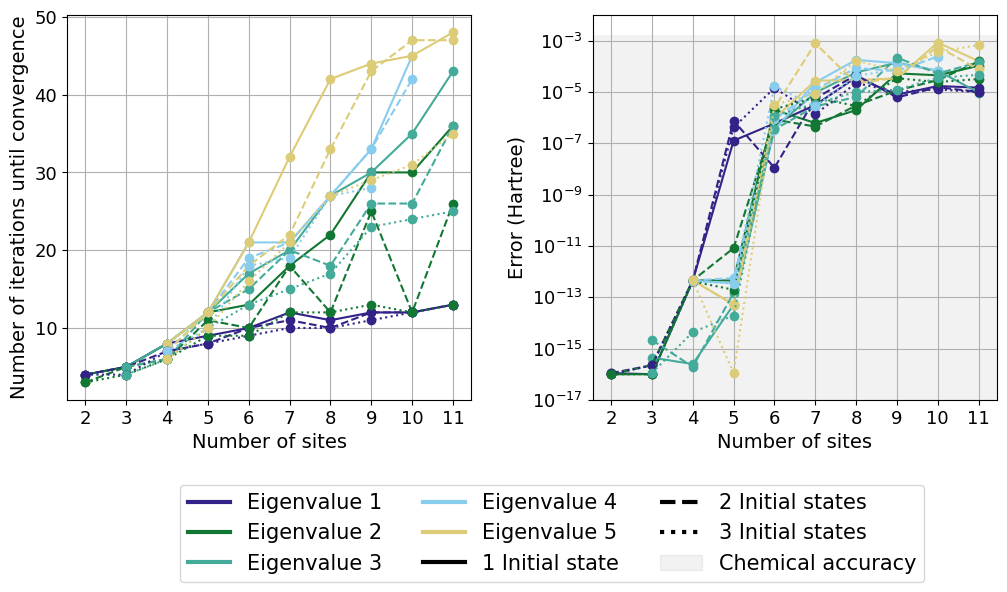

In [7]:


# --- Configuration ---
Nstates = 5
sites_list = list(range(2, 12))
overlap= 0.5
markers = ['o', 's', '^', 'D', 'x']
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499']
lines = ['-', '--', ':']
num_tracks_per_state = 10

lines_dic = {str(i + 1): lines[i] for i in range(3)}
color_dic = {f'Eigenvalue {i+1}': colors[i] for i in range(Nstates)}
markers_dic = {f'Initial state overlap {overlap_list[i]}': markers[i] for i in range(1)}

handles = [
    *[mlines.Line2D([], [], color=color, label=label, linewidth=3) for label, color in color_dic.items()],
    *[mlines.Line2D([], [], color='black', linestyle=lines_dic[str(i+1)], linewidth=3, label=f"{i+1} Initial state") for i in range(1)],
    *[mlines.Line2D([], [], color='black', linestyle=lines_dic[str(i+1)], linewidth=3, label=f"{i+1} Initial states") for i in range(1,3)],
    mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')
]

# --- Plot Setup ---
plt.figure(figsize=(12, 5))

# --- Main Loop ---
for inits in range(3):
    Ninitial = inits + 1
    for target_state in range(Nstates):
        sites_iter, sites_list_plot, error_list_plot = [], [], []

        for sites in sites_list:
            size = 2 ** sites

            with open(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl', 'rb') as f:
                data = pkl.load(f)
            eigvals = np.unique(np.round(np.sort(data['eigvals']), 12))
            norm_val = data['norm']
            suffix = f"{overlap * 10}"
            if inits == 0:
                tag = f"{suffix}"
            elif inits == 1:
                tag = f"{suffix}_2nd{suffix}"
            elif inits == 2:
                tag = f"{suffix}_2nd{suffix}_3rd{overlap}"

            with open(f'{Data_path}/T_{sites}_200Heisenberg_line_3evol_random_overlap{tag}.pkl', 'rb') as f:
                T = pkl.load(f)
            with open(f'{Data_path}/S_{sites}_200Heisenberg_line_3evol_random_overlap{tag}.pkl', 'rb') as f:
                S = pkl.load(f)

            # Setup tracking lists
            list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
            list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

            i = 1
            while i < 60:
                dim = Ninitial * i
                Ttemp, Stemp = T[:dim, :dim], S[:dim, :dim]

                # SVD cleanup
                s, V, d = np.linalg.svd(Stemp)
                s, d = np.conj(s).T, np.conj(d).T
                idxs = np.where(V > 1e-10)[0]

                Ttemp = d @ Ttemp @ s
                Stemp = d @ Stemp @ s
                Ttemp = Ttemp[idxs, :][:, idxs]
                Stemp = Stemp[idxs, :][:, idxs]

                # Solve GEP
                eigsv = linalg.eig(Ttemp, Stemp)[0]
                eigsv_angle = -np.angle(eigsv)
                eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3
                eigsv_angle = np.sort(eigsv_angle)

                assigned = [set() for _ in range(Nstates)]

                for elem in eigsv_angle:
                    near, idx = find_nearest(eigvals, elem)
                    if idx != target_state:
                        continue

                    diffs, valid_idxs = [], []
                    for k in range(num_tracks_per_state):
                        track_idx = num_tracks_per_state * idx + k
                        if track_idx in assigned[idx] or i in list_iter[track_idx]:
                            continue
                        if list_iter[track_idx] and i != list_iter[track_idx][-1] + 1:
                            continue
                        valid_idxs.append(track_idx)
                        diffs.append(0.01 if not list_eigs[track_idx] else abs(list_eigs[track_idx][-1] - elem))

                    if diffs:
                        best_idx = valid_idxs[np.argmin(diffs)]
                        assigned[idx].add(best_idx)
                        if (len(list_eigs[best_idx]) > 1 and
                            abs(list_eigs[best_idx][-1] - elem) < 1e-4 and
                            abs(elem - list_eigs[best_idx][-2]) < 1e-4 and
                            list_iter[best_idx][-1] == i - 1):
                            sites_iter.append(i)
                            sites_list_plot.append(sites)
                            error = abs(elem - eigvals[idx])
                            error_list_plot.append(error if error > 1e-16 else 1e-16)
                            i = np.inf
                            break
                        list_eigs[best_idx].append(elem)
                        list_iter[best_idx].append(i)
                i += 1

        plt.subplot(1, 2, 1)
        plt.plot(sites_list_plot, sites_iter, color=colors[target_state], linestyle=lines[inits], marker='o')

        plt.subplot(1, 2, 2)
        plt.plot(sites_list_plot, error_list_plot, color=colors[target_state], linestyle=lines[inits], marker='o')

# --- Final Plot Adjustments ---
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 2, 1)
plt.grid()
plt.xlabel('Number of sites', fontsize=14)
plt.ylabel('Number of iterations until convergence', fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(sites_list, fontsize=13)

plt.subplot(1, 2, 2)
plt.grid()
plt.xlabel('Number of sites', fontsize=14)
plt.ylabel('Error (Hartree)', fontsize=14)
plt.yscale('log')
plt.ylim(1e-17, 1e-2)
plt.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
plt.xticks(sites_list, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(handles=handles, fontsize=15, loc='lower center', ncol=3, bbox_to_anchor=(-0.1, -0.5))
plt.savefig(f'{Data_path}/figure3.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Evolution time

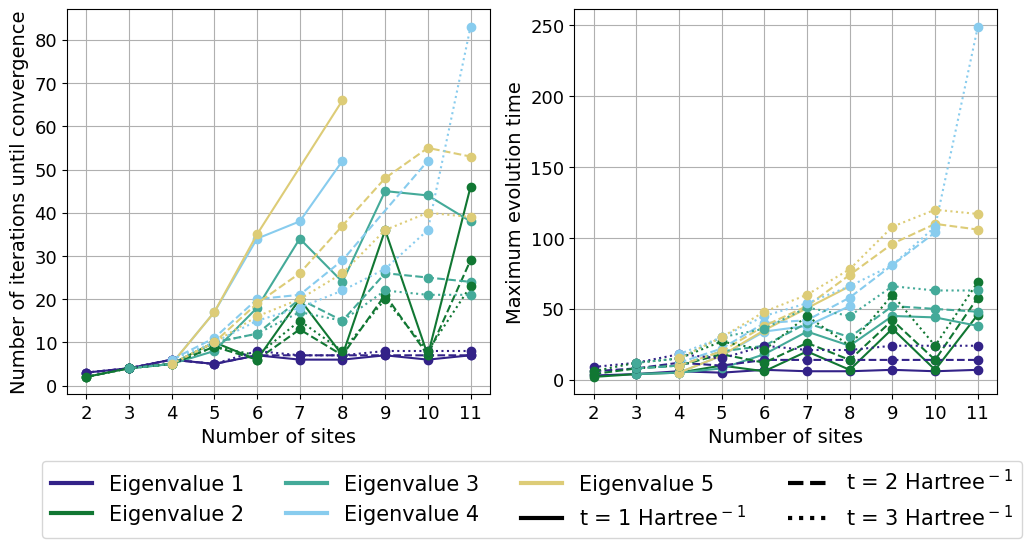

In [9]:

# --- Configuration ---
Nstates = 5  # Number of eigenstates to track
Ninitial = 2  # Number of initial states
sites_list = [2,3,4,5,6,7,8,9,10,11]  # System sizes
overlap_list = [0.5]  # Overlap values

# --- Plotting Configuration ---
# 5 markers for 5 different overlaps
markers = ['o', 's', '^', 'D', 'x']
num_tracks_per_state = 10  # Number of tracking sublists per eigenstate 
colors = ['#332288', '#117733', '#44AA99','#88CCEE','#DDCC77','#CC6677','#AA4499']
lines = ['-', '--', ':']
lines_dic = {f'{i+1}': lines[i] for i in range(3)}
color_dic = {f'Eigenvalue {i+1}': colors[i] for i in range(Nstates)}
lines_handles = [mlines.Line2D([], [], color='black', label=f"t = {i+1} Hartree$^-$$^1$", linestyle=lines_dic[str(i+1)], linewidth=3) for i in range(3)]
color_handles = [mlines.Line2D([], [], color=color, label=f"{T}", linewidth=3) for T, color in color_dic.items()]
handles = color_handles + lines_handles
plt.figure(figsize=(12, 5))

# Initialize subplot index
index_p = 1  

# --- Main Loop ---
for evtime in range(3):
    
    for target_state in [0,1,2,3,4]:
        sites_iter = []
        sites_list_plot = []
        for sites in sites_list:
            over_idx = 0
            #for overlap in overlap_list:
            size = 2** sites

            with open(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl', 'rb') as f:
                dic = pkl.load(f)

            eigvals = np.unique(np.round(np.sort(dic['eigvals']), 12))
            eigvecs = dic['eigvecs']
            norm_val = dic['norm']
            if evtime == 2:
                # Load T and S matrices
                with open(f'{Data_path}/T_{sites}_200Heisenberg_line_{evtime+1}evol_random_overlap{0.5*10}_2nd{0.5*10}.pkl', 'rb') as f:
                    T = pkl.load(f)
                with open(f'{Data_path}/S_{sites}_200Heisenberg_line_{evtime+1}evol_random_overlap{0.5*10}_2nd{0.5*10}.pkl', 'rb') as f:
                    S = pkl.load(f)
            else:
                # Load T and S matrices
                with open(f'{Data_path}/T_{sites}_200Heisenberg_line_{evtime+1}evol_random_overlap{0.5*10}_2nd{0.5}.pkl', 'rb') as f:
                    T = pkl.load(f)
                with open(f'{Data_path}/S_{sites}_200Heisenberg_line_{evtime+1}evol_random_overlap{0.5*10}_2nd{0.5}.pkl', 'rb') as f:
                    S = pkl.load(f)
            

            # Storage for tracking
            list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
            list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

            # Iterate over time steps
            i = 1
            while i < 100:
                Ttemp = T[:Ninitial*i, :Ninitial*i]
                Stemp = S[:Ninitial*i, :Ninitial*i]

                # SVD cleanup
                s, V, d = np.linalg.svd(Stemp)
                s = np.conj(s).T
                d = np.conj(d).T
                idxs = np.where(V > 1e-10)[0]
                Ttemp = d@Ttemp@s
                Stemp = d@Stemp@s
                Ttemp = Ttemp[idxs, :][:, idxs]
                Stemp = Stemp[idxs, :][:, idxs]

                # Solve generalized eigenvalue problem
                eigsv = linalg.eig(Ttemp, Stemp)[0]
                eigsv_angle = -np.angle(eigsv)
                eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < evtime+1.000001] * norm_val / (evtime+1)
                eigsv_angle = np.sort(eigsv_angle)

                assigned_sublists = [set() for _ in range(Nstates)]  # Prevent reuse within same iteration

                # Assign each eigenvalue to a sublist
                for elem in eigsv_angle:
                    near, idx = find_nearest(eigvals, elem)
                   
                    if idx != target_state:
                        continue
            
                    temp_diffs = []
                    valid_idxs = []

                    for k in range(num_tracks_per_state):
                        list_idx = num_tracks_per_state * idx + k

                        # Skip if already assigned or duplicate iteration
                        if list_idx in assigned_sublists[idx]:
                            continue
                        if i in list_iter[list_idx]:
                            continue

                        # Ensure continuity
                        if len(list_iter[list_idx]) > 0 and i != list_iter[list_idx][-1] + 1:
                            continue

                        valid_idxs.append(list_idx)

                        if len(list_eigs[list_idx]) == 0:
                            temp_diffs.append(0.01)
                        else:
                            prev_val = list_eigs[list_idx][-1]
                            temp_diffs.append(abs(prev_val - elem))

                    # Assign to best-matching track
                    if temp_diffs:
                        best_idx = valid_idxs[np.argmin(temp_diffs)]
                        if len(list_eigs[best_idx])>0 and np.abs(list_eigs[best_idx][-1]-eigvals[idx]) < 1.6e-3 and np.abs(elem-eigvals[idx])< 1.6e-3 and list_iter[best_idx][-1]== i-1:
                            sites_iter.append(i)
                            sites_list_plot.append(sites)
                            i=np.inf
                            break
                        list_eigs[best_idx].append(elem)
                        list_iter[best_idx].append(i)
                        assigned_sublists[idx].add(best_idx)
                i += 1
        plt.subplot(1, 2, 1)
        plt.plot(sites_list_plot,sites_iter, color=colors[target_state],linestyle=lines[evtime],marker= 'o')
        plt.subplot(1, 2, 2)
        plt.plot(sites_list_plot,[i*(evtime+1) for i in sites_iter], color=colors[target_state],linestyle=lines[evtime],marker= 'o')
plt.subplot(1, 2, 1)
plt.grid()
plt.xlabel('Number of sites',fontsize=14)
plt.ylabel('Number of iterations until convergence',fontsize=14)
plt.xticks(sites_list,fontsize=13)
plt.yticks(fontsize=13)
plt.subplot(1, 2, 2)
plt.grid()
plt.xlabel('Number of sites',fontsize=14)
plt.ylabel('Maximum evolution time',fontsize=14)
plt.xticks(sites_list,fontsize=13)
plt.yticks(fontsize=13)
plt.legend(handles=handles,fontsize=15,loc='lower center',ncol=4,bbox_to_anchor=(-0.1, -0.4))
plt.savefig(f'{Data_path}/Heisenberg_convergenceci_evol123v2F.pdf',format='pdf', bbox_inches='tight')
plt.show()

# Precision limited

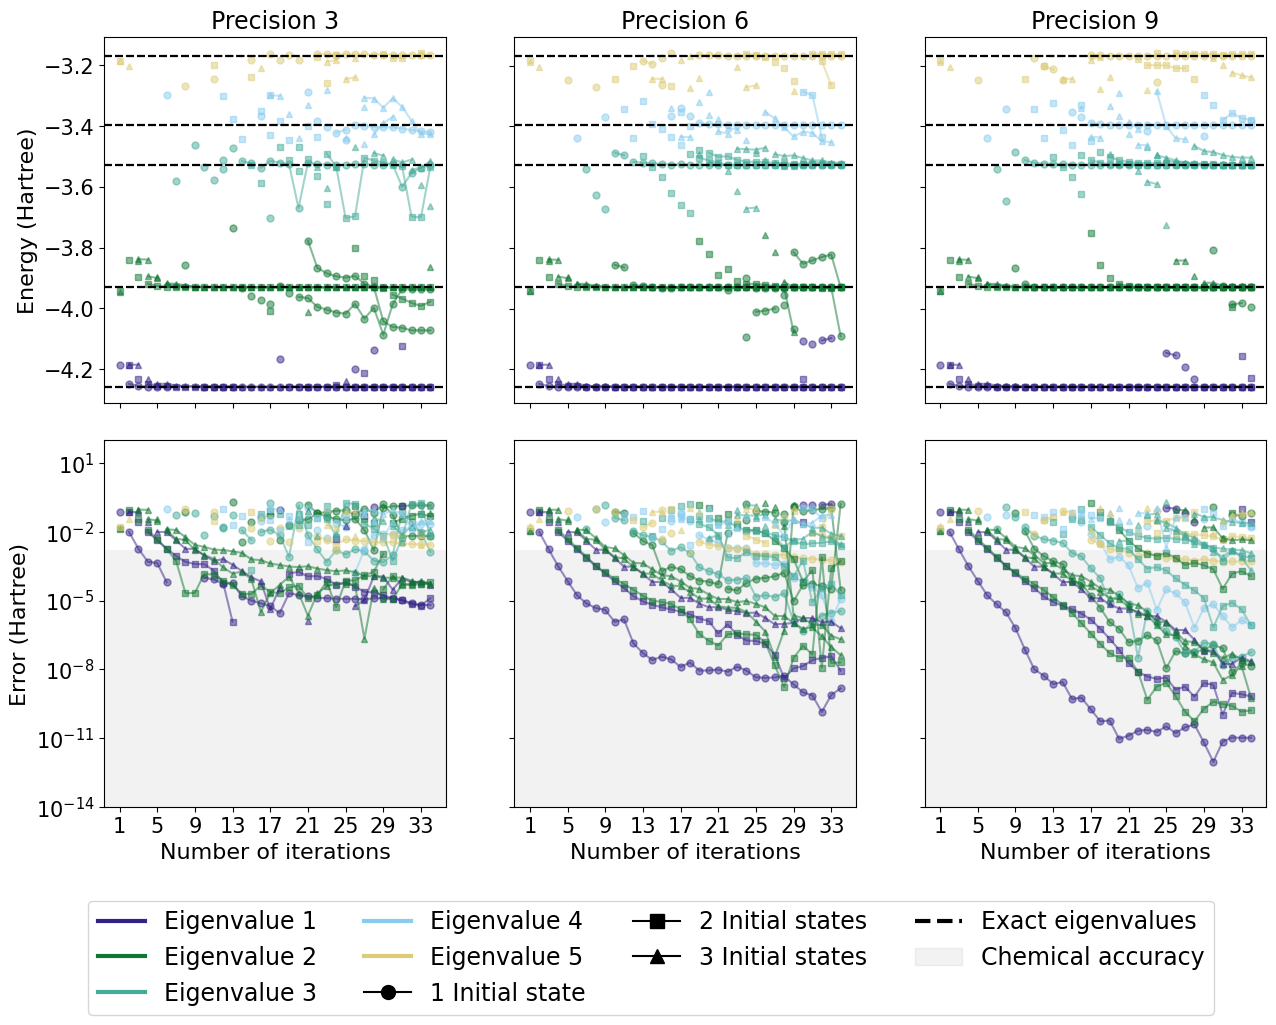

In [8]:


# --- Configuration ---
Nstates = 5          # Number of eigenstates to track
Ninitial = 2         # Number of initial states
sites_list = [10]    # System sizes (not used explicitly here)
overlap_list = [0.1, 0.3, 0.5]
markers = ['o', 's', '^', 'D', 'x']  # For different overlaps
num_tracks_per_state = 10
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77']

# Line and patch handles for legend
line_styles = ['--']
lines_handles = [mlines.Line2D([], [], color='black', label="Exact eigenvalues", linestyle=ls, linewidth=3) for ls in line_styles]
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]

# Color and marker dictionaries for legend
color_dic = {f'Eigenvalue {i+1}': colors[i] for i in range(Nstates)}
markers_dic = {f'{i} Initial state{"s" if i>1 else ""}': markers[i-1] for i in range(1, 4)}

color_handles = [mlines.Line2D([], [], color=color, label=label, linewidth=3) for label, color in color_dic.items()]
overlap_handles = [mlines.Line2D([], [], color='black', label=label, marker=marker, markersize=10, linestyle='-')
                   for label, marker in markers_dic.items()]
handles = color_handles + overlap_handles + lines_handles + gray_region_handle



# --- Plot Setup ---
plt.figure(figsize=(15, 10))
sites = 10
index_p = 1  # Subplot row index

# --- Main Loop ---
for precision in [3, 6, 9]:
    over_idx = 0
    for inits in [1, 2, 3]:
        size = 2 ** sites
        
        # Load eigenvalues, eigenvectors, and norm value once per (sites)
        with open(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl', 'rb') as f:
            dic = pkl.load(f)
        eigvals = np.unique(np.round(np.sort(dic['eigvals']), 12))
        eigvecs = dic['eigvecs']
        norm_val = dic['norm']

        # Load T and S based on initial states
        overlap_val = 0.5 * 10
        base_path = f'{Data_path}/'
        if inits == 1:
            T_file = f'T_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}.pkl'
            S_file = f'S_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}.pkl'
        elif inits == 2:
            T_file = f'T_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}_2nd{overlap_val}.pkl'
            S_file = f'S_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}_2nd{overlap_val}.pkl'
        else:  # inits == 3
            T_file = f'T_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}_2nd{overlap_val}_3rd0.5.pkl'
            S_file = f'S_{sites}_200Heisenberg_line_3evol_random_overlap{overlap_val}_2nd{overlap_val}_3rd0.5.pkl'

        with open(base_path + T_file, 'rb') as f:
            T = pkl.load(f)
        with open(base_path + S_file, 'rb') as f:
            S = pkl.load(f)

        # Tracking lists for eigenvalues and iterations
        list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
        list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

        # Iterate over steps
        for i in range(1, 35):
            dim = Ninitial * i
            Ttemp = T[:dim, :dim]
            Stemp = S[:dim, :dim]

            Ttemp = np.round(Ttemp, precision)
            Stemp = np.round(Stemp, precision)

            # SVD cleanup to improve numerical stability
            s, V, d = np.linalg.svd(Stemp)
            cuttof = 10 ** (-precision - 1)
            idxs = np.where(V > cuttof)[0]
            Ttemp = d @ Ttemp @ s
            Stemp = d @ Stemp @ s
            Ttemp = Ttemp[idxs][:, idxs]
            Stemp = Stemp[idxs][:, idxs]

            # Solve generalized eigenvalue problem
            eigsv = linalg.eig(Ttemp, Stemp)[0]
            eigsv_angle = -np.angle(eigsv)
            eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3
            eigsv_angle = np.sort(eigsv_angle)

            assigned_sublists = [set() for _ in range(Nstates)]  # To avoid reuse in same iteration

            # Assign each eigenvalue to a tracking sublist
            for elem in eigsv_angle:
                near, idx = find_nearest(eigvals, elem)
                if idx >= Nstates:
                    continue

                temp_diffs = []
                valid_idxs = []

                for k in range(num_tracks_per_state):
                    list_idx = num_tracks_per_state * idx + k

                    # Skip if already assigned or duplicate iteration or discontinuous
                    if list_idx in assigned_sublists[idx] or i in list_iter[list_idx]:
                        continue
                    if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                        continue

                    valid_idxs.append(list_idx)
                    if not list_eigs[list_idx]:
                        temp_diffs.append(0.01)  # default small diff if no previous value
                    else:
                        temp_diffs.append(abs(list_eigs[list_idx][-1] - elem))

                if temp_diffs:
                    best_idx = valid_idxs[np.argmin(temp_diffs)]
                    list_eigs[best_idx].append(elem)
                    list_iter[best_idx].append(i)
                    assigned_sublists[idx].add(best_idx)

        # --- Plot Results ---
        for p in range(num_tracks_per_state * Nstates):
            state_idx = p // num_tracks_per_state

            plt.subplot(2, 3, index_p)
            plt.plot(list_iter[p], list_eigs[p], color=colors[state_idx], marker=markers[over_idx],
                     markersize=5, alpha=0.5)

            plt.subplot(2, 3, index_p + 3)
            plt.plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), color=colors[state_idx],
                     marker=markers[over_idx], markersize=5, alpha=0.5)

        # Draw horizontal lines at exact eigenvalues
        plt.subplot(2, 3, index_p)
        for val in eigvals[:5]:
            plt.axhline(y=val, color='black', linestyle='--')

        over_idx += 1
    index_p += 1

# Formatting x-axis ticks and labels
ite = np.arange(1, 35, 4)
ite2 = np.arange(1, 35, 8)

for i in range(1, 4):
    axt = plt.subplot(2, 3, i)

    if i == 1:
        axt.set_ylabel('Energy (Hartree)', fontsize=16)
        axt.tick_params('y', labelsize=15)
    else:
        axt.set_yticklabels([])
        axt.tick_params('y', labelsize=15, labelleft=False)

    axt.set_xticks(ite)
    axt.set_xticklabels([])
    axt.set_title(f'Precision {3 * i}', fontsize=17)

   

    ax = plt.subplot(2, 3, i + 3)
    ax.set_xlabel('Number of iterations', fontsize=16)
    if i == 1:
        ax.set_ylabel('Error (Hartree)', fontsize=16)
        ax.tick_params('y', labelsize=15)
    else:
        ax.set_yticklabels([])
        ax.tick_params('y', labelsize=15, labelleft=False)

    ax.set_xticks(ite)
    ax.set_xticklabels(ite, size=15)

    ax.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    ax.set_ylim(1e-14, 100)
    ax.set_yscale('log')

   

plt.subplots_adjust(hspace=0.1)
legend = plt.legend(handles=handles, loc='lower center', fontsize=17, bbox_to_anchor=(-0.8, -0.6), ncol=4)

plt.savefig(f'{Data_path}/figure7.pdf', format='pdf', bbox_inches='tight')


### S threshold

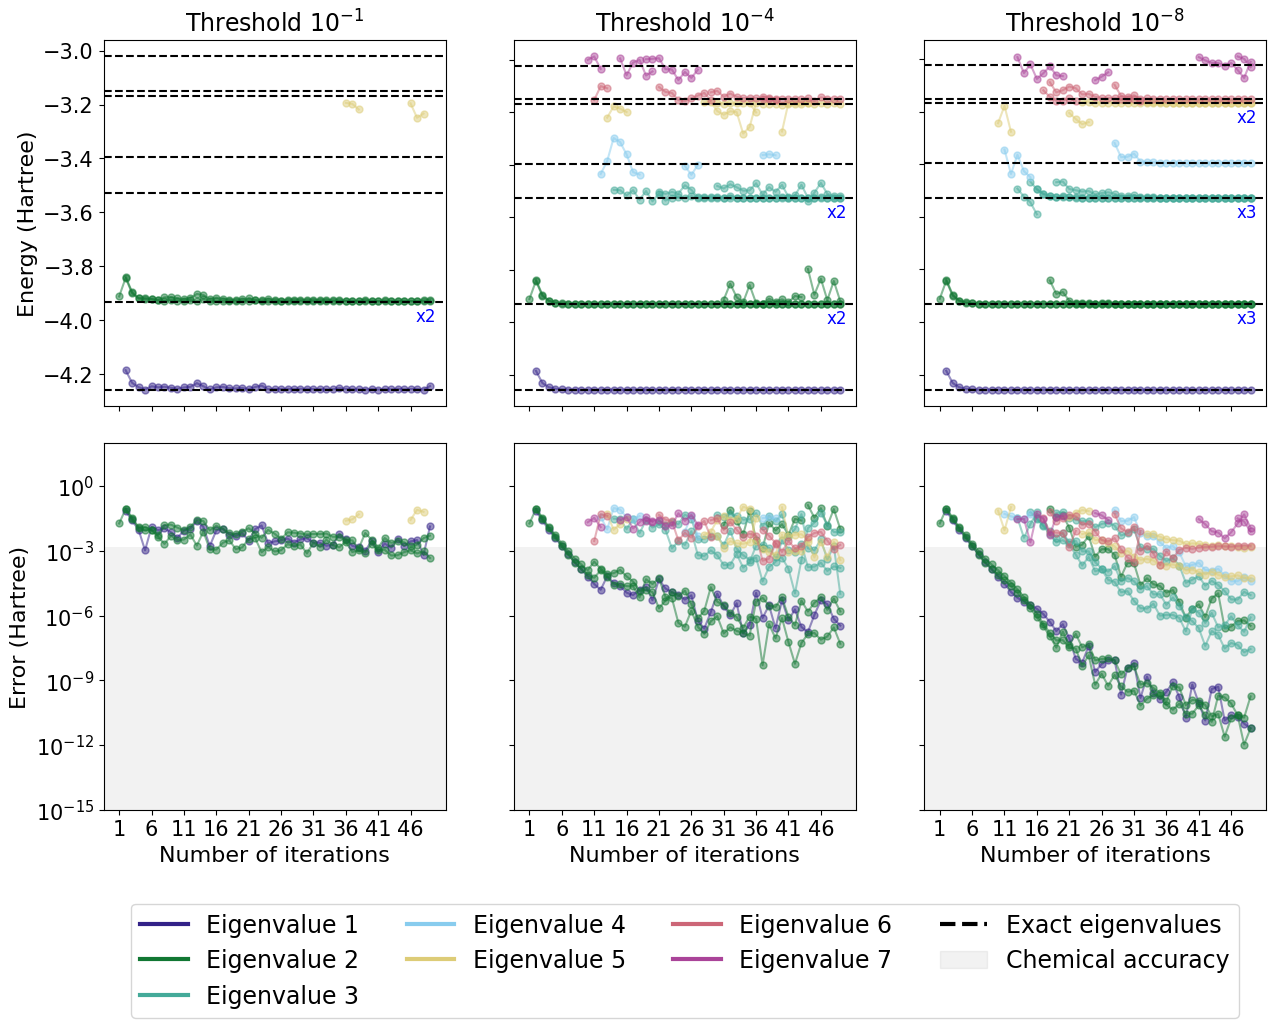

In [6]:


# --- Configuration ---
T8 = [1, 3, 3, 1, 2]
T4 = [1, 2, 2, 1, 1]
T1 = [1, 2, 1, 1, 1]

Nstates = 7
Ninitial = 1
sites_list = [10]
overlap_list = [0.1, 0.3, 0.5, 0.7, 0.9]
markers = ['o', 's', '^', 'D', 'x']
num_tracks_per_state = 10
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499']

color_dic = {f'Eigenvalue {i + 1}': colors[i] for i in range(Nstates)}
markers_dic = {f'Initial state overlap {val}': markers[i] for i, val in enumerate(overlap_list)}

color_handles = [
    mlines.Line2D([], [], color=color, label=label, linewidth=3)
    for label, color in color_dic.items()
]
overlap_handles = [
    mlines.Line2D([], [], color='black', label=label, marker=marker, markersize=10)
    for label, marker in markers_dic.items()
]
line_handles = [mlines.Line2D([], [], color='black', label="Exact eigenvalues", linestyle='--', linewidth=3)]
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
handles = color_handles + line_handles + gray_region_handle


# --- Plot Setup ---
plt.figure(figsize=(15, 10))
sites = 10
overlap = 0.5
index_p = 1

# --- Main Loop ---
for thrs in [1, 4, 8]:
    over_idx = 0
    Ninitial = 3
    size = 2**sites
    second_overlap = third_overlap = overlap

    # Load eigen data
    with open(f'{Data_path}/eigvals_eigvecs_norm_{sites}_heisenberg_line_3evol.pkl', 'rb') as f:
        dic = pkl.load(f)
    eigvals = np.unique(np.round(np.sort(dic['eigvals']), 12))
    norm_val = dic['norm']

    # Load evolution data
    suffix = f"{sites}_200Heisenberg_line_3evol_random_overlap{overlap*10}_2nd{second_overlap*10}_3rd{third_overlap}"
    with open(f'{Data_path}/T_{suffix}.pkl', 'rb') as f:
        T = pkl.load(f)
    with open(f'{Data_path}/S_{suffix}.pkl', 'rb') as f:
        S = pkl.load(f)

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    for i in range(1, 50):
        size_i = Ninitial * i
        Ttemp = T[:size_i, :size_i]
        Stemp = S[:size_i, :size_i]

        # SVD Cleanup
        s, V, d = np.linalg.svd(Stemp)
        s, d = np.conj(s).T, np.conj(d).T
        cutt = 10**-thrs
        idxs = np.where(V > cutt)[0]

        Ttemp = d @ Ttemp @ s
        Stemp = d @ Stemp @ s
        Ttemp = Ttemp[np.ix_(idxs, idxs)]
        Stemp = Stemp[np.ix_(idxs, idxs)]

        # Generalized eigenvalue problem
        eigsv = linalg.eig(Ttemp, Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3
        eigsv_angle = np.sort(eigsv_angle)

        assigned_sublists = [set() for _ in range(Nstates)]

        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs = []
            valid_idxs = []

            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k

                if list_idx in assigned_sublists[idx] or i in list_iter[list_idx]:
                    continue
                if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)
                last_val = list_eigs[list_idx][-1] if list_eigs[list_idx] else 0
                temp_diffs.append(abs(last_val - elem) if list_eigs[list_idx] else 0.1)

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    # --- Plot Results ---
    for p in range(num_tracks_per_state * Nstates):
        state_idx = p // num_tracks_per_state
        if len(list_eigs[p]) < 3:
            continue

        plt.subplot(2, 3, index_p)
        plt.plot(list_iter[p], list_eigs[p], color=colors[state_idx], marker=markers[over_idx], markersize=5, alpha=0.5)

        plt.subplot(2, 3, index_p + 3)
        plt.plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), color=colors[state_idx], marker=markers[over_idx], markersize=5, alpha=0.5)

    plt.subplot(2, 3, index_p)
    for k in range(Nstates):
        plt.axhline(y=eigvals[k], color='black', linestyle='--')

    index_p += 1

# --- Axis Formatting ---
ite = np.arange(1, 50, 5)
ite2 = np.arange(1, 50, 10)
multiplicities = [T1, T4, T8]

for i in range(1, 4):
    ax = plt.subplot(2, 3, i)
    if i == 1:
        ax.set_ylabel('Energy (Hartree)', fontsize=16)
        ax.set_title('Threshold $10^{-1}$', fontsize=17)
    elif i == 2:
        ax.set_title('Threshold $10^{-4}$', fontsize=17)
    else:
        ax.set_title('Threshold $10^{-8}$', fontsize=17)

    ax.set_xticks(ite)
    ax.set_xticklabels([])
    ax.tick_params('y', labelsize=15)
    if i > 1:
        ax.set_yticklabels([])

    for mul_id, mul in enumerate(multiplicities[i - 1]):
        if mul != 1:
            y_offset = 0.07 if (i == 3 and mul_id == 5) else -0.02
            ax.text(50, eigvals[mul_id] + y_offset, f'x{mul}', fontsize=12, color='blue', ha='right', va='top')

    

    # Bottom row: error plot
    ax_err = plt.subplot(2, 3, i + 3)
    ax_err.set_xlabel('Number of iterations', fontsize=16)
    ax_err.set_xticks(ite)
    ax_err.set_xticklabels(ite, size=15)
    ax_err.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    ax_err.set_yscale('log')
    ax_err.set_ylim(1e-15, 100)

    if i == 1:
        ax_err.set_ylabel('Error (Hartree)', fontsize=16)
        ax_err.tick_params('y', labelsize=15)
    else:
        ax_err.set_yticklabels([])
        ax_err.tick_params('y', labelsize=15, labelleft=False)

    

# Final adjustments and save
plt.subplots_adjust(hspace=0.1)
plt.legend(handles=handles, loc='lower center', fontsize=17, bbox_to_anchor=(-0.7, -0.6), ncol=4)
plt.savefig(f'{Data_path}/figure9.pdf', format='pdf', bbox_inches='tight')
plt.show()
